# 0. Imports

In [111]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import seaborn as sns
import math
from PIL import Image as im

# 1. Load data

You can download this data set from: https://www.cs.toronto.edu/~kriz/cifar.html

In [6]:
!mkdir -p 'data'
!tar -xzvf 'data/cifar-100-python.tar.gz' -C 'data'

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [52]:
# Unpickling and loading dataset function
def unpickle(file):
    """
    Function: Unpickle the files given a path
    Args:
        file (str): The filepath of the file to unpickle
    Returns:
        data_dictionary (dict): The unpickled dictionary
    """
    with open(file, 'rb') as f:
        data_dictionary = pickle.load(f, encoding='bytes')
    return data_dictionary

In [53]:
def convert_byte_strings_to_strings(data_dictionary):
    """
    Function: Convert byte strings to strings
    Args:
        data_dictionary (dict): The dictionary to convert
    Returns:
        data_dictionary_str (dict): The converted dictionary
    """

    # Instance an empty object
    data_dictionary_str = {}

    # Typecast the train dataset
    for key in data_dictionary.keys():

        # Change byte strings to strings
        if type(data_dictionary[key][0]) == str:
            data_dictionary_str[key.decode("utf-8")] = [item.decode("utf-8") for item in data_dictionary[key]]

        # Else just later the key strings
        else:
            data_dictionary_str[key.decode("utf-8")] = data_dictionary[key]

    return data_dictionary_str

In [54]:
# Unpickling the files
def load_CIFR_data(dir: str, label_type: str = "fine_labels"):
    """
    Function: Load the data from pickle files
    Args:
        path (str): The  path to directory containg the pickle files of CIFR
        label_type (str): The type of labels to return
    """
    # Validate label_type
    if label_type not in ["fine_labels", "coarse_labels"]:
        raise ValueError("label_type must be one of fine_labels or coarse_labels")

    # Load the train data set
    train_data_object =  unpickle(f'{dir}/train')

    # String converted dictionary
    train_data = convert_byte_strings_to_strings(train_data_object)

    # Load the test data set
    test_data_object =  unpickle(f'{dir}/test')

    # String converted dictionary
    test_data = convert_byte_strings_to_strings(test_data_object)

    # Label encoding object set
    label_translation_object =  unpickle(f'{dir}/meta')

    # String converted dictionary
    label_translation = convert_byte_strings_to_strings(label_translation_object)

    return train_data, test_data, label_translation

In [55]:
# Type of train
train_obj, test_obj, label_obj = load_CIFR_data('./data/cifar-100-python')

# 2. Data Exploration

Each data dictionary has 5 keys:

* filenames : That is the name of the picture file
* batch_label : *Unknown*
* fine_labels : 100 labels precisely identifying each image
* coarse_labels : 20 labels approximately identifying image
* data : The tensor of each 32x32x3 image as a 3072,1 shape tensor

## 2.1 Let's eavluate the coarse labels data format and augment it according to our needs

### 2.1.1 Number of coarse labels

In [57]:
print(set(train_obj['coarse_labels']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [58]:
print(len(set(train_obj['coarse_labels'])))

20


### 2.1.2 Number of Fine labels

In [59]:
print(set(train_obj['fine_labels']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


In [60]:
print(len(set(train_obj['fine_labels'])))

100


### 2.1.3 Creating a hash map to lookup the lable to the class name

In [89]:
def label_to_class(label, label_translation, as_onehot=False, label_type: str = "fine_label_names"):
    """
    Function: Convert a label to a class text
    Args:
        label (int | np.array): The label to convert
        label_translation (dict): The label translation dictionary
        as_onehot (bool): Whether the label is onehot or not
    """
    # Validate label_type
    if label_type not in ["fine_label_names", "coarse_label_names"]:
        raise ValueError("label_type must be one of fine_label_names or coarse_label_names")


    # Get the label from onehot is passed as onehot
    if as_onehot:
        try:
            label = int(np.argmax(label))
        except Exception as e:
            print(e)
            print(label)
            raise ValueError("Label must be onehot") from e

    # Get the label_string
    try:
        label_string = label_translation[label_type][label]

    except Exception as e:
        print(e)
        print(label)
        raise ValueError("Label must be an integer") from e

    return label_string.decode("utf-8")

## 2.2 Check label distribution in the train set

In [93]:
hist = {}
for val in train_obj['fine_labels']:
    if val not in hist:
        hist[val] = 1
    else:
        hist[val] += 1

<BarContainer object of 100 artists>

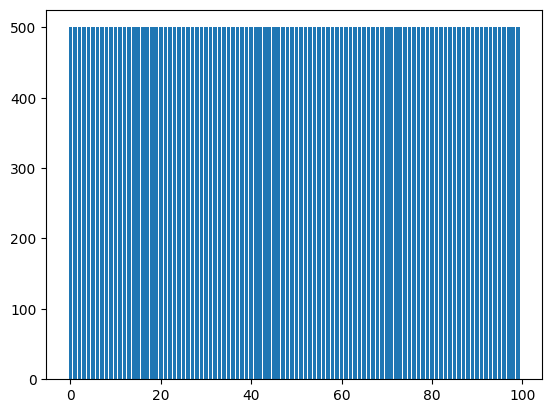

In [97]:
plt.bar(x=list(hist.keys()), height=list(hist.values()))

## 2.3 Check label distribution in the test set

In [98]:
hist = {}
for val in test_obj['fine_labels']:
    if val not in hist:
        hist[val] = 1
    else:
        hist[val] += 1

<BarContainer object of 100 artists>

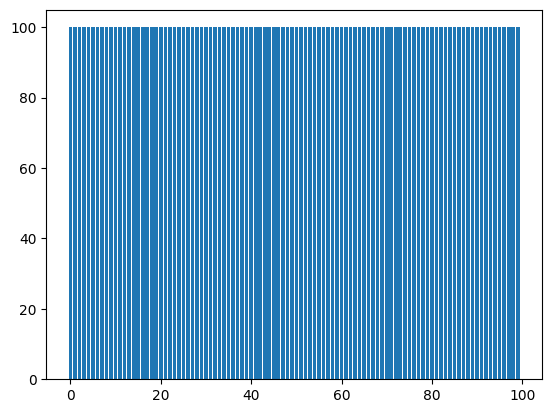

In [99]:
plt.bar(x=list(hist.keys()), height=list(hist.values()))

## 2.4 Tansform the dataset from 10,000 x 3072 x 1 to 10,000 x 32 x 32 x 3

### 2.4.1 Transforming the data

In [141]:
def transform_tensor(input_tensor, channels=3):
    """
    Function: Transform the tensor from 10,000 x 3072 x 1 to 10,000 x 32 x 32 x 3
    Args:
        input_tensor (np.array): The input tensor
    Returns:
        output_tensor (np.array): The output tensor
    """
    # Get sample dimesion metadata
    samples = input_tensor.shape[0]
    flattened_dim = input_tensor.shape[1]/channels

    # Reshape tensor
    output_tensor = tf.reshape(input_tensor, (samples, channels, math.ceil(flattened_dim**0.5), math.ceil(flattened_dim**0.5)))
    output_tensor = tf.transpose(output_tensor, perm=[0, 2, 3, 1])

    # Return the output tensor
    return output_tensor

In [142]:
train_dataset_X = transform_tensor(train_obj['data'])
test_dataset_X = transform_tensor(test_obj['data'])

### 2.4.2 Validating the shape

In [143]:
train_dataset_X.shape

TensorShape([50000, 32, 32, 3])

In [144]:
test_dataset_X.shape

TensorShape([10000, 32, 32, 3])

## 2.5 Displaying an image using PIL

### 2.5.1 From train split

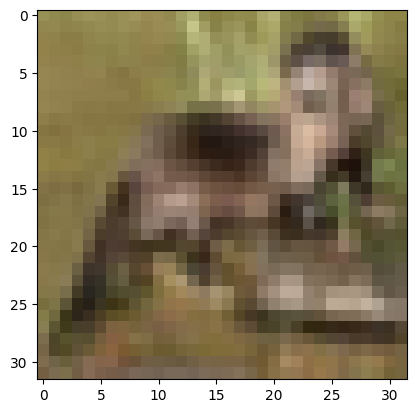

In [145]:
plt.imshow(train_dataset_X[100])

### 2.5.2 From test split

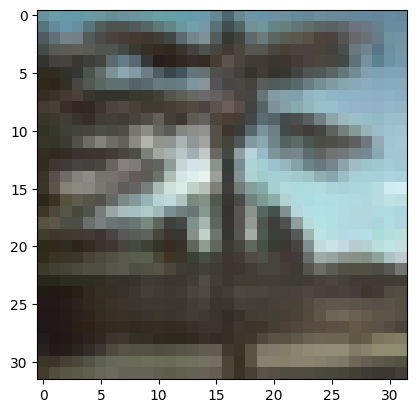

In [147]:
plt.imshow(test_dataset_X[5000])

## 2.6 Encoding the labels into a onehot encode format

### 2.6.1 Encode the int labels as onehots

In [151]:
def label_to_onehot(label, label_translation, label_type: str = "fine_label_names"):
    """
    Function: Convert a label to a onehot encode
    Args:
        label (int | np.array): The label to convert
        label_translation (dict): The label translation dictionary
    """

    # Validate label_type
    if label_type not in ["fine_label_names", "coarse_label_names"]:
        raise ValueError("label_type must be one of fine_label_names or coarse_label_names")

    # Convert singular label to a list
    if type(label) not in (list, set, tf.Tensor, np.array):
        try:
            labels = np.array([int(label)])
        except Exception as e:
            raise ValueError("Label must be an number or numeric list") from e

    else:
        labels = label

    # Initialise an empty array for return
    result = []

    # For each element return the onehot
    for label in labels:
        onehot = np.zeros(len(label_translation[label_type]))
        onehot[label] = 1
        result.append(onehot)

    # Return the result
    return tf.constant(result)

In [152]:
train_dataset_Y = label_to_onehot(train_obj['fine_labels'], label_obj)
test_dataset_Y = label_to_onehot(test_obj['fine_labels'], label_obj)

### 2.6.2 Validate size of output

In [153]:
train_dataset_Y.shape

TensorShape([50000, 100])

In [154]:
test_dataset_Y.shape

TensorShape([10000, 100])

# 3. Modelling

ValueError: Computed output size would be negative. Received `inputs shape=(None, 0, 0, 4)`, `kernel shape=(32, 32, 4, 4)`, `dilation_rate=[1 1]`.